#### Imports

In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import keras
pd.options.display.max_colwidth = 100
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import MobileNet
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image as k_im_prep
from keras.models import Model
from keras import backend as K
from keras.models import Sequential

#### Training Data

output is list of paths to images and list of corresponding labels

In [2]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_tr=studies[studies[0].str.contains("WRIST")==True]
wrist_tr=np.array(wrist_tr)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_tr=[]
wrist_labels_tr=[]
for i in tqdm( range(wrist_tr.shape[0]) ):
    study_path=wrist_tr[i][0]
    study_label=wrist_tr[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_tr.append(study_path + image)
        wrist_labels_tr.append(study_label)

wrist_paths_tr=np.array(wrist_paths_tr)
wrist_labels_tr=np.array(wrist_labels_tr)

100%|██████████| 3460/3460 [01:15<00:00, 46.10it/s]


### Todo : issue , images after preprocessing look different

read images from paths to array of images

In [31]:
wrist_images_tr=[]
for path in tqdm(wrist_paths_tr):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_tr.append(np.array(wrist))

wrist_images_tr=np.array(wrist_images_tr)

print(wrist_images_tr.shape)

100%|██████████| 5000/5000 [00:50<00:00, 61.78it/s] 


(5000, 224, 224, 3)


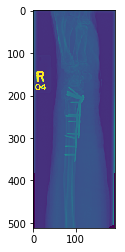

In [4]:
#visualizing random sample
index=999
plt.imshow(wrist_images_tr[index])
print(wrist_labels_tr[index])

#### Validation Data

In [ ]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_tr=studies[studies[0].str.contains("WRIST")==True]
wrist_tr=np.array(wrist_tr)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_val=[]
wrist_labels_val=[]
for i in tqdm( range(wrist_tr.shape[0]) ):
    study_path=wrist_tr[i][0]
    study_label=wrist_tr[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_val.append(study_path + image)
        wrist_labels_val.append(study_label)

wrist_paths_val=np.array(wrist_paths_val)
wrist_labels_val=np.array(wrist_labels_val)

wrist_images_val=[]
for path in tqdm(wrist_paths_val):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_val.append(np.array(wrist))

wrist_images_val=np.array(wrist_images_val)

print(wrist_images_val.shape)

#visualizing random sample
index=999
plt.imshow(wrist_images_val[index])
print(wrist_labels_val[index])


### Model

#### TODO : see if want to freeze less layers

In [11]:
MobileNetV2_model = MobileNetV2(input_shape= (224, 224, 3),weights='imagenet', include_top=False)
for layer in MobileNetV2_model.layers:
  layer.trainable= False 
MobileNetV2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

#### TODO
* could we add precision or recall metric ? change accuracy?
* why doesn't it work if removed GlobalAveragePooling line?
* 

In [27]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(224,224,3))

# a layer instance is callable on a tensor, and returns a tensor
x = MobileNetV2_model(inputs)
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_31 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total para

In [34]:
model.fit(wrist_images_val, wrist_labels_tr, epochs=5, validation_split=0.2, shuffle=True, verbose=1 )  # starts training
#TODO: add class_weight parameter dictionary of weights to each class index

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 445s 111ms/step - loss: 1.0721 - acc: 0.9327 - val_loss: 11.8611 - val_acc: 0.2560
Epoch 2/5
4000/4000 [==============================] - 442s 111ms/step - loss: 1.0721 - acc: 0.9327 - val_loss: 11.8611 - val_acc: 0.2560
Epoch 3/5
4000/4000 [==============================] - 461s 115ms/step - loss: 1.0721 - acc: 0.9327 - val_loss: 11.8611 - val_acc: 0.2560
Epoch 4/5
 864/4000 [=====>........................] - ETA: 4:53 - loss: 1.0702 - acc: 0.9329

KeyboardInterrupt: 

#### Current point: now generalizing wrist model to all wrist data and moving to colab + seeing early stopping callback